## Productionising a Classification Problem (Using the Titanic dataset)

This notebook demonstrates how to productionise a Machine Learning model using the `pipeline` module in sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). It allows you to pickle (https://docs.python.org/3/library/pickle.html) the whole workflow (ETL - extract, transform, load and the ML model itself) into a pipeline. This can then be run when needed (e.g. when new data comes in) or be scheduled as a cronjob. You can also use GridSearch and RandomSearch with this pipeline :).

As the aim fo this notebook is to show you how to productionise your model, it skips the EDA, does very limited hyperparameter tuning and does not analyse the of outputs. If you are interested in how to approach a classification problem in the first place, please have a look at this notebook: https://github.com/natskr/classification101/blob/master/Classification%20101%20-%20Using%20the%20Titanic%20dataset.ipynb. 

#### Importing standard packages & custom Classes & Functions

In [1]:
#import standard packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.externals import joblib

#import ML packages
from sklearn.preprocessing import (
    OneHotEncoder, # includes LabelEncoder as of scikit-learn 0.20
    StandardScaler,
    LabelEncoder)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import (
    RandomizedSearchCV, 
    GridSearchCV, 
    train_test_split, 
    KFold
    )
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix)

#import pipelining packages
from sklearn.base import (
    TransformerMixin, # provides fit_transform method
    BaseEstimator) # provides get_params & set_params methods
from collections import defaultdict
from sklearn.pipeline import (
    Pipeline, 
    FeatureUnion
    )

# class used in the pipeline to select which colums to manipulate 
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__( self, feature_names):
        self.feature_names = feature_names 
        # self._feature_names = feature_names  
        # usually this should be used but GridSearchCV and RandomSearchCV 
        # require the self.feature_names version: 
        # https://stackoverflow.com/questions/50523930/
        # custom-transformers-and-gridsearch-valueerror-in-pipeline

    def fit( self, X, y = None ):
        return self
    
    def transform( self, X, y = None ):
        return X[self.feature_names]
        # return X[self._feature_names]

# LabelEncoder used for the tree algorithmn pipeline (excluding OneHotEncoding)
class MultiColumnLabelEncoder(TransformerMixin):  
    def __init__(self):
        self.d = defaultdict(LabelEncoder)

    def transform(self, X, **transform_params):
        X = X.fillna('NaN')  
        transformed = X.apply(lambda x: self.d[x.name].transform(x))
        return transformed

    def fit(self, X, y=None, **fit_params):
        X = X.fillna('NaN')  
        X.apply(lambda x: self.d[x.name].fit(x))
        return self    

# some functions used in the script to plot and calculate model accuracy, etc. metrics
def get_confusion_matrix(y_true, y_pred, normalise=False):
    cm = confusion_matrix(y_true, y_pred)
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return cm

def plot_train_test_confusion_matrix_side_by_side(train_cm, test_cm):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
    sns.heatmap(train_cm , annot=True, ax=ax1)
    sns.heatmap(test_cm , annot=True, ax=ax2)
    ax1.set(title='Train Confusion Matrix')
    ax2.set(title='Test Confusion Matrix');
    fig.set_size_inches(18, 7)
    
    #Function to display the ROC Curve
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, var):
    fig=plt.plot(fpr, tpr, label='Train')
    fig=plt.plot(fpr_tst, tpr_tst, label='Test')
    plt.plot([0, 1], [0, 1],'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC Curve")
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('RoC.png')
    #save(output+'roc_'+var, ext="png", close=False, verbose=True)  
    plt.show() 
    
    #Confusion Matrix for Train Data
def test_train_output(gs_fit, X_train, y_train, X_test, y_test):
    print('Train:')
    print('Accuracy:',"%.2f" % (accuracy_score(y_train, gs_fit.predict(X_train))*100), '%')
    print ("Recall:","%.2f" % (recall_score(y_train, gs_fit.predict(X_train))*100), '%')
    print ("Precision:","%.2f" % (precision_score(y_train, gs_fit.predict(X_train))*100), '%')
    AUC_Train = roc_auc_score(y_train, gs_fit.predict_proba(X_train)[:,1])
    print ("AUC:", "%0.2f" % (AUC_Train*100), '%')
    print ("Confusion Matrix:\n", confusion_matrix(y_train,gs_fit.predict(X_train)))
  
    print('Test:')
    print ("Accuracy:","%.2f" % (accuracy_score(y_test, gs_fit.predict(X_test))*100), '%')
    print ("Recall:","%.2f" % (recall_score(y_test, gs_fit.predict(X_test))*100), '%')
    print ("Precision:","%.2f" % (precision_score(y_test, gs_fit.predict(X_test))*100), '%')
    AUC_Test = roc_auc_score(y_test, gs_fit.predict_proba(X_test)[:,1])
    print ("AUC:", "%0.2f" %  (AUC_Test * 100), '%')
    print ("Confusion Matrix:\n", confusion_matrix(y_test,gs_fit.predict(X_test)))

    fpr, tpr, thresholds = roc_curve(y_train,gs_fit.predict_proba(X_train)[:,1])
    fpr_tst, tpr_tst, thresholds = roc_curve(y_test, gs_fit.predict_proba(X_test)[:,1])
    roc_plot(fpr, tpr, fpr_tst, tpr_tst, "Logit")

    train_cm = get_confusion_matrix(y_train, gs_fit.predict(X_train), normalise=True)
    test_cm = get_confusion_matrix(y_test, gs_fit.predict(X_test), normalise=True)
    plot_train_test_confusion_matrix_side_by_side(train_cm, test_cm) 

### Import Titanic dataset & do basic column cleaning

In [2]:
# defining constants that will be used later on
SEED = 13
RANDOM_SEEDS = 42
TEST_SIZE = 0.3

# read in dataset, do basic cleaning on columns and rows
df = pd.read_csv('titanic.csv')
df.drop(['ticket','cabin','boat','body'], axis=1, inplace=True)
df_nonull = df[(df['fare'].notnull()) & (df['embarked'].notnull())] 

# identify categorical variables
X_cat = df_nonull.drop('survived', axis=1).select_dtypes(include=['object'])
cat = X_cat.columns.tolist()

# identify continuous variables
X_cont = df_nonull.drop('survived', axis=1).select_dtypes(include=['float64'])
cont = X_cont.columns.tolist()

print('Categorical Columns:', cat, '\nContinuous Columns:', cont)

# merge categorical and continuous features and do the train/test split
X = X_cat.merge(X_cont, left_index=True, right_index=True)
y = df_nonull['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEEDS)

Categorical Columns: ['sex', 'embarked'] 
Continuous Columns: ['pclass', 'age', 'sibsp', 'parch', 'fare']


### Pipeline
For a more extensive description of how Pipelines work in scikit-learn please read https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65. For a worked through example please have a look below.

The Pipeline looks different for Logistic Regression and Tree Algorithms:
* Logistic Regression requires the scaling continuous variables, Tree Algorithms do not.
* Logistic Regression requires OneHotEncoding of categorical variables, Tree Algorithms do not.

The classes used in this pipeline are described below:

**FeatureSelector**: A custom class that selects which columns should be used for the next pipeline steps.

**SimpleImputer**: Imputes missing values, here it imputes the median value https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

**StandardScaler**: Standard Scales the numerical variables to mean=0 and std=1 which is needed for Logistic Regression.

**OneHotEncoder**: As of scikit-learn 0.20 this class converts categorical variables to integers and then OneHotEncodes them so they are columns with 1 or 0, again needed for Logistic Regression.

**MultiColumnLabelEncoder**: Custom class used to LabelEncode columns for Tree Algorithms.

**FeatureUnion**: A class that combines the continuous and the categorical pipelines together, and then feeds the output to the model build within the next Pipeline.

### GridSearch in Pipelines

When you use GridSearchCV / RandomSearchCV with a Pipeline you have to use the following 
naming convention for the search parameters:

```
model_pipeline = Pipeline([('feature_union', feature_union), 
                           ('model', LogisticRegression())])
                    
C --> model__C
solver --> model__solver
penalty --> model__penalty
```

-----------------------------------------------------------------------------

### Pipeline for Logistic Regression

#### Untuned Logistic Regression model

Train:
Accuracy: 79.32 %
Recall: 68.41 %
Precision: 74.68 %
AUC: 84.89 %
Confusion Matrix:
 [[489  80]
 [109 236]]
Test:
Accuracy: 79.08 %
Recall: 68.63 %
Precision: 75.54 %
AUC: 82.11 %
Confusion Matrix:
 [[205  34]
 [ 48 105]]


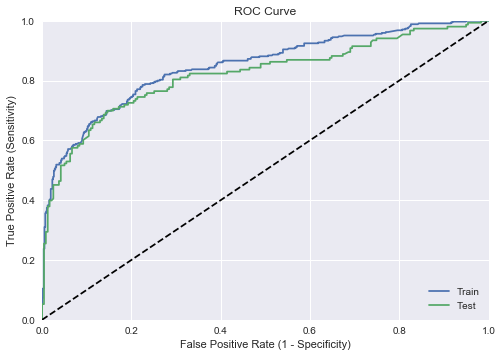

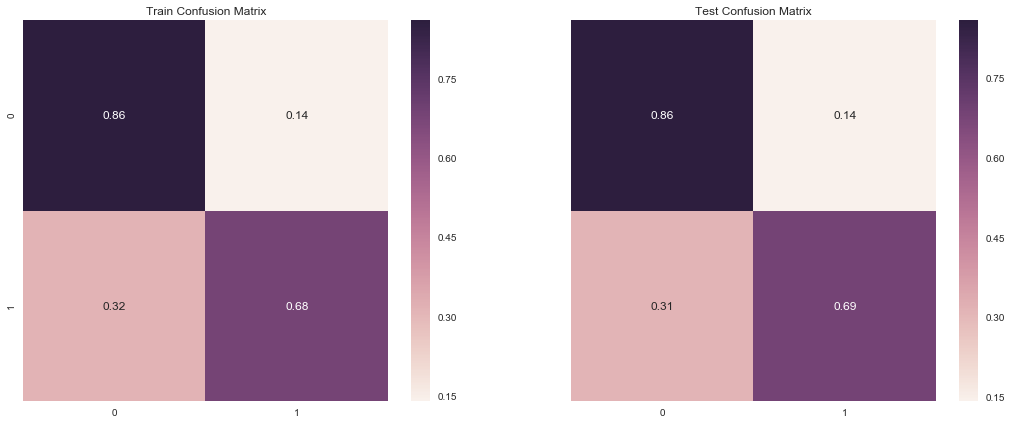

In [3]:
# continuous pipeline
continuous_pipeline_lg = Pipeline(
    steps = [('cont_selector', FeatureSelector(cont)),
             ('imputer', SimpleImputer(missing_values = np.nan, strategy = 'median')),
             ('std_scaler', StandardScaler())
            ])

# categorical pipeline
categorical_pipeline_lg = Pipeline(
    steps = [('cat_selector', FeatureSelector(cat)),
             ('one_hot_encoder', OneHotEncoder(sparse = False, categories='auto'))
            ])

# combine both pipelines together
feature_union = FeatureUnion(
    transformer_list = [('continuous_pipeline', continuous_pipeline_lg),
                       ('categorical_pipeline', categorical_pipeline_lg)
                       ])

#fit untuned Logistic Regression model
model_pipeline_lg = Pipeline([('feature_union', feature_union),
                              ('logistic_regression', LogisticRegression(solver='lbfgs'))
                             ])

model_output_lg = model_pipeline_lg.fit(X_train,y_train)
y_pred = model_output_lg.predict(X_test)
y_prob_pred = model_output_lg.predict_proba(X_test)

test_train_output(model_output_lg, X_train, y_train, X_test, y_test)

#### GridSearch for Logistic Regression

Train:
Accuracy: 79.87 %
Recall: 68.41 %
Precision: 75.88 %
AUC: 84.91 %
Confusion Matrix:
 [[494  75]
 [109 236]]
Test:
Accuracy: 79.59 %
Recall: 67.97 %
Precision: 77.04 %
AUC: 82.34 %
Confusion Matrix:
 [[208  31]
 [ 49 104]]


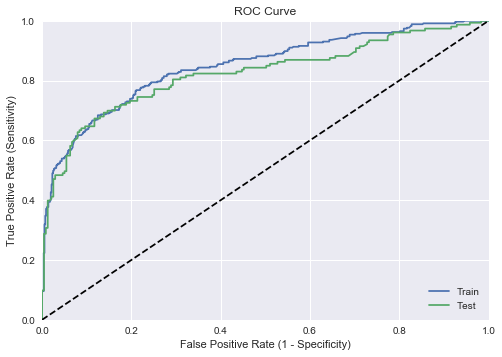


Best LG estimators: Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('continuous_pipeline', Pipeline(memory=None,
     steps=[('cont_selector', FeatureSelector(feature_names=['pclass', 'age', 'sibsp', 'parch', 'fare'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=na...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))]) 
Best LG parameters: {'logistic_regression__C': 0.1, 'logistic_regression__penalty': 'l2', 'logistic_regression__solver': 'newton-cg'} 
Best LG score: 0.8444797644131998


['Titanic_LogReg.pkl']

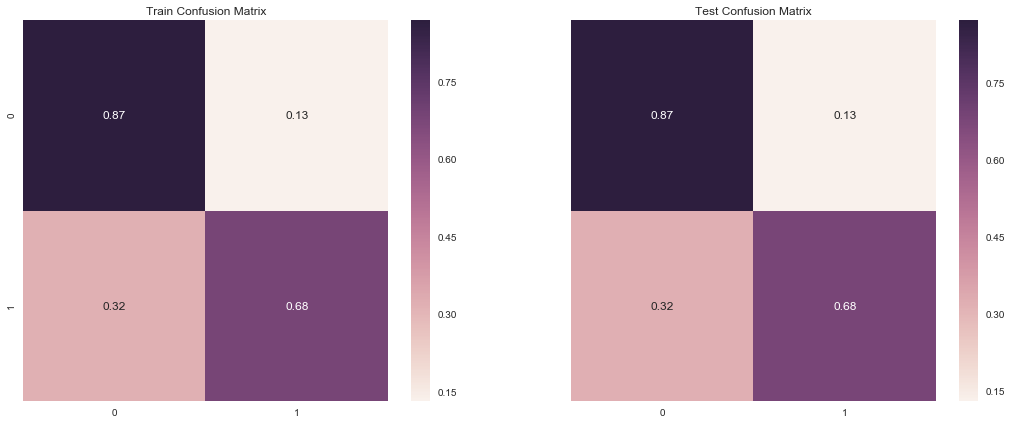

In [4]:
# K-Fold cross validation, here I use 5 folds
kf_lr = KFold(n_splits=5, shuffle=False, random_state=SEED)

# parameter space that GridSearchCV will search for Logistic Regression
param_grid_logreg = [{'logistic_regression__C': [0.001, 0.01, 0.1, 1], 
                      'logistic_regression__solver': ['liblinear'], 
                      'logistic_regression__penalty':['l1']}, 
                     {'logistic_regression__C': [0.001, 0.01, 0.1, 1], 
                      'logistic_regression__solver': ['newton-cg', 'lbfgs', 'liblinear'],
                      'logistic_regression__penalty':['l2']},
                    ]

# GridsearchCV using the pipeline output 
grid = GridSearchCV(model_pipeline_lg, 
                    param_grid_logreg, 
                    cv = kf_lr, 
                    scoring='roc_auc',
                    error_score='raise')

# fitting the Logistic Regression model
model_output = grid.fit(X_train, y_train)
y_pred = model_output.predict(X_test)
y_pred_proba = model_output.predict_proba(X_test)

test_train_output(grid, X_train, y_train, X_test, y_test)

print('\nBest LG estimators:', grid.best_estimator_, 
      '\nBest LG parameters:', grid.best_params_, 
      '\nBest LG score:', grid.best_score_)

# save ETL process and best Logistic Regression model as a pickle file
joblib.dump(grid.best_estimator_,'Titanic_LogReg.pkl', compress = 1)


## Pipeline for Tree Algorithms (XGBoost, RandomForestClassifier)

In [5]:
# continuous pipeline
continuous_pipeline_tree = Pipeline(
    steps = [('cont_selector', FeatureSelector(cont)),
             ('imputer', SimpleImputer(missing_values = np.nan, strategy = 'median')),
            ])

# categorical pipeline
categorical_pipeline_tree = Pipeline(
    steps = [('cat_selector', FeatureSelector(cat)),
             ('label_encoder', MultiColumnLabelEncoder())
            ])

# combining the two pipelines
feature_union_tree = FeatureUnion(
    transformer_list = [('continuous_pipeline', continuous_pipeline_tree),
                       ('categorical_pipeline', categorical_pipeline_tree)
                       ])

#### Untuned XGBoost

Train:
Accuracy: 85.78 %
Recall: 73.33 %
Precision: 86.94 %
AUC: 92.56 %
Confusion Matrix:
 [[531  38]
 [ 92 253]]
Test:
Accuracy: 79.85 %
Recall: 68.63 %
Precision: 77.21 %
AUC: 84.15 %
Confusion Matrix:
 [[208  31]
 [ 48 105]]


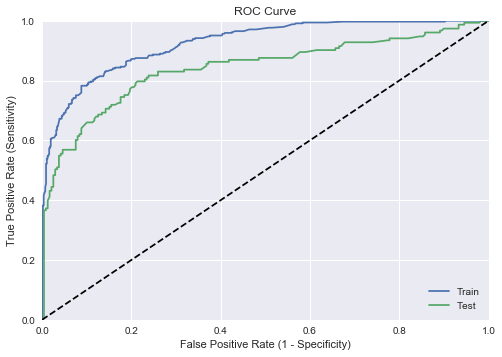

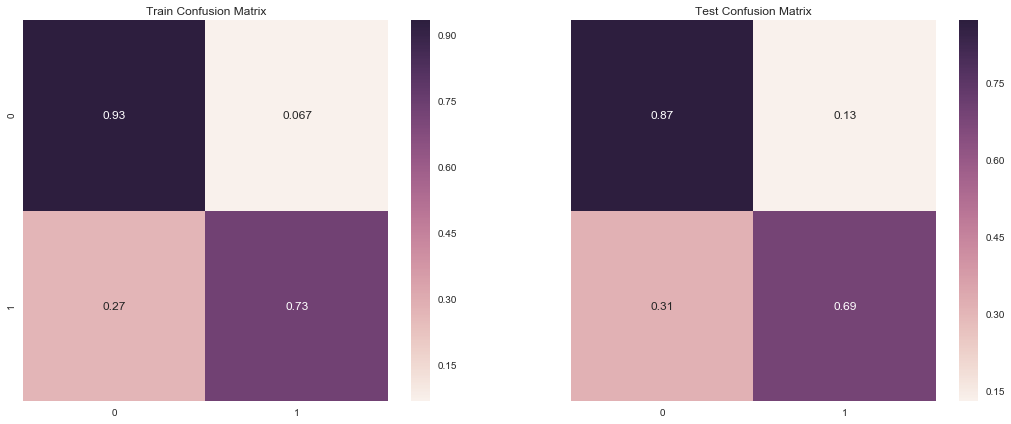

In [6]:
# fit untuned XGBoost model
model_pipeline_xgb = Pipeline([('feature_union', feature_union_tree), 
                                ('xgboost', XGBClassifier())
                               ])

model_pipeline_xgb = model_pipeline_xgb.fit(X_train,y_train)
y_pred = model_pipeline_xgb.predict(X_test)
y_prob_pred = model_pipeline_xgb.predict_proba(X_test)

test_train_output(model_pipeline_xgb, X_train, y_train, X_test, y_test)

#### GridSearch for XGBoost

Train:
Accuracy: 58.32 %
Recall: 99.13 %
Precision: 47.50 %
AUC: 91.20 %
Confusion Matrix:
 [[191 378]
 [  3 342]]
Test:
Accuracy: 51.28 %
Recall: 93.46 %
Precision: 44.14 %
AUC: 83.89 %
Confusion Matrix:
 [[ 58 181]
 [ 10 143]]


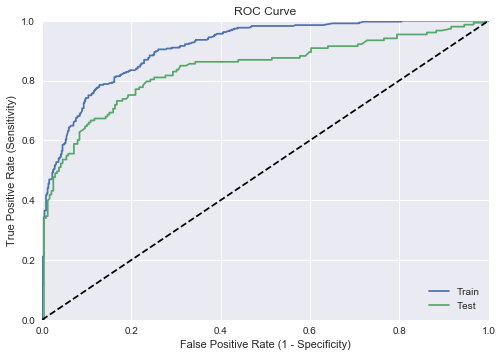


Best XGB estimator: Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('continuous_pipeline', Pipeline(memory=None,
     steps=[('cont_selector', FeatureSelector(feature_names=['pclass', 'age', 'sibsp', 'parch', 'fare'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=na...istic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=10, seed=0, silent=True, subsample=0.8))]) 
Best XGB parameters: {'xgboost__subsample': 0.8, 'xgboost__scale_pos_weight': 10, 'xgboost__n_estimators': 300, 'xgboost__min_child_weight': 4, 'xgboost__max_depth': 2, 'xgboost__learning_rate': 0.05, 'xgboost__gamma': 0.1, 'xgboost__colsample_bytree': 0.6} 
Best XGB score: 0.8537109953977747


['Titanic_XGB.pkl']

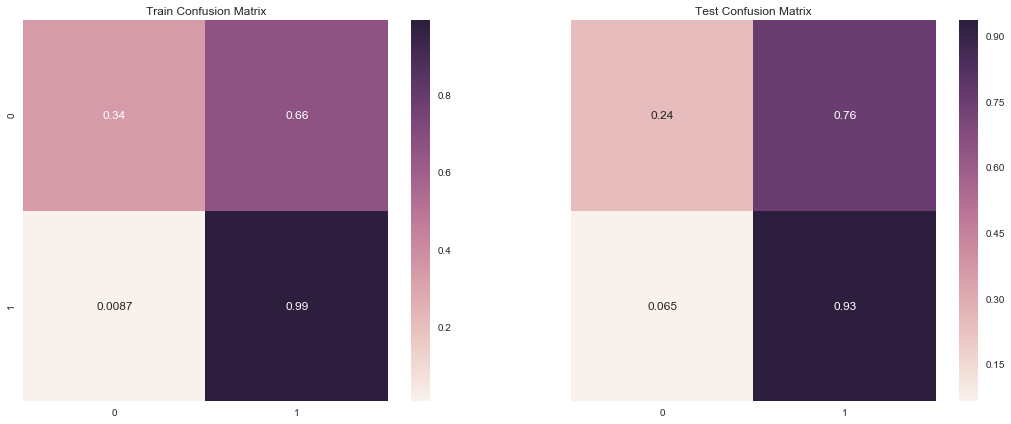

In [7]:
# parameter space RandomizedSearchCV will search for XGBoost
param_test_xgb = {'xgboost__n_estimators': [260, 280, 300, 320, 340],
                  'xgboost__scale_pos_weight': [0.38, 1, 2.62, 3.5, 10, 15],
                  'xgboost__max_depth': np.arange(2,6,1),
                  'xgboost__min_child_weight': np.arange(1,6,1), 
                  'xgboost__gamma':[i/10.0 for i in range(0,5)],
                  'xgboost__subsample':[i/10.0 for i in range(7,11)],
                  'xgboost__colsample_bytree':[i/10.0 for i in range(2,7)],
                  'xgboost__learning_rate':np.arange(0.05,0.3,0.05)
                 } 

# RandomizedSearchCV using the pipeline output 
xgb = RandomizedSearchCV(model_pipeline_xgb, 
                        param_test_xgb,
                        n_iter=200,
                        n_jobs=8,
                        scoring='roc_auc',
                        cv=3)

# fitting the XGBoost model
xgb.fit(X_train,y_train.values.ravel())

test_train_output(xgb, X_train, y_train, X_test, y_test)

print('\nBest XGB estimator:', xgb.best_estimator_, 
      '\nBest XGB parameters:', xgb.best_params_,
      '\nBest XGB score:', xgb.best_score_)

# save ETL process and best XGBoost model as a pickle file
joblib.dump(xgb.best_estimator_, 'Titanic_XGB.pkl', compress = 1)

#### Untuned Random Forest Classifier

//anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train:
Accuracy: 96.39 %
Recall: 92.75 %
Precision: 97.56 %
AUC: 99.30 %
Confusion Matrix:
 [[561   8]
 [ 25 320]]
Test:
Accuracy: 75.26 %
Recall: 66.67 %
Precision: 68.92 %
AUC: 81.39 %
Confusion Matrix:
 [[193  46]
 [ 51 102]]


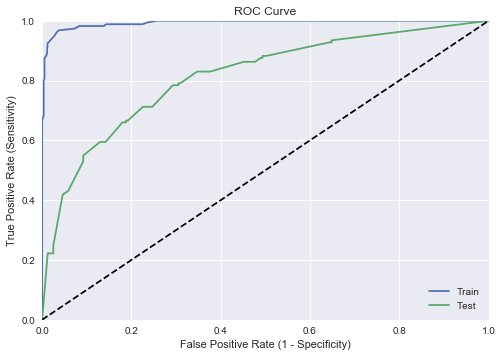

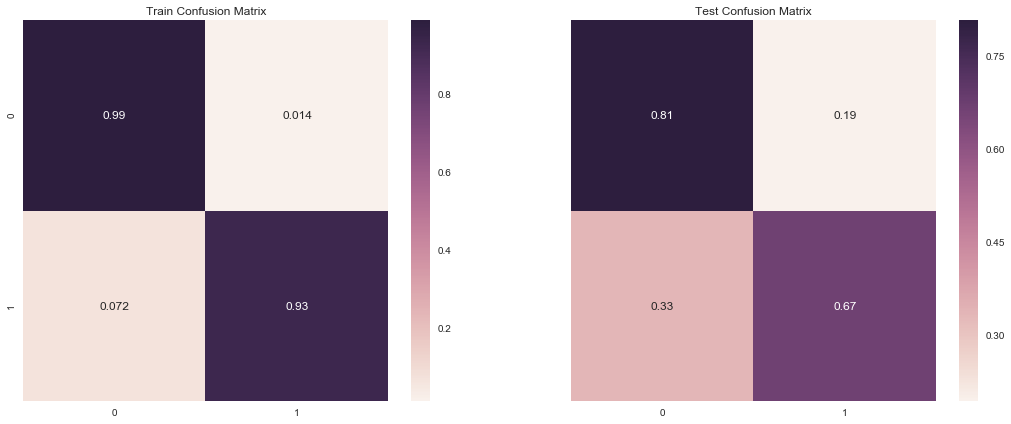

In [8]:
# fit untuned RandomForestClassifier
model_pipeline_rfc = Pipeline([('feature_union', feature_union_tree), 
                               ('rfc', RandomForestClassifier())
                              ])

model_pipeline_rfc = model_pipeline_rfc.fit(X_train,y_train)
y_pred = model_pipeline_rfc.predict(X_test)
y_prob_pred = model_pipeline_rfc.predict_proba(X_test)

test_train_output(model_pipeline_rfc, X_train, y_train, X_test, y_test)

#### RandomSearch for RandomForestClassifier

Train:
Accuracy: 88.29 %
Recall: 77.68 %
Precision: 89.93 %
AUC: 94.78 %
Confusion Matrix:
 [[539  30]
 [ 77 268]]
Test:
Accuracy: 80.36 %
Recall: 68.63 %
Precision: 78.36 %
AUC: 85.12 %
Confusion Matrix:
 [[210  29]
 [ 48 105]]


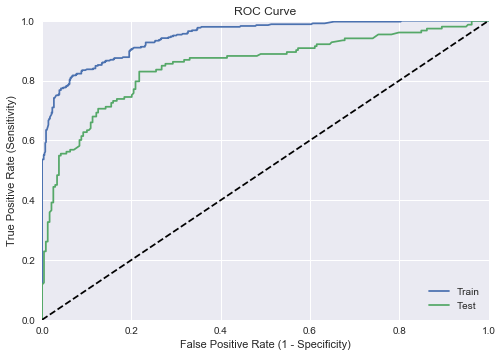


Best RFC estimators: Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=None,
       transformer_list=[('continuous_pipeline', Pipeline(memory=None,
     steps=[('cont_selector', FeatureSelector(feature_names=['pclass', 'age', 'sibsp', 'parch', 'fare'])), ('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=na...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]) 
Best RFC parameters: {'rfc__n_estimators': 110, 'rfc__max_features': None, 'rfc__max_depth': 7, 'rfc__criterion': 'entropy', 'rfc__class_weight': None} 
Best RFC score: 0.8612123818622172


['Titanic_RFC.pkl']

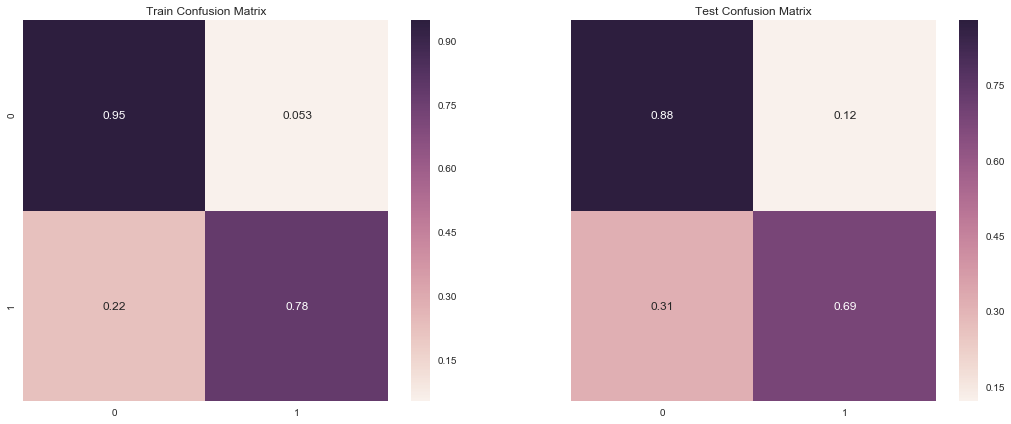

In [9]:
# parameter space RandomizedSearchCV will search for the RandomForestClassifier
param_test_rfc = {'rfc__criterion': ['entropy','gini'],
                  'rfc__max_features': ['auto', 'sqrt', 'log2', None],
                  'rfc__class_weight': ['balanced', 'balanced_subsample', None],
                  'rfc__max_depth': np.arange(1,8,1),
                  'rfc__n_estimators': [80, 90, 100, 110, 120, 130, 140, 150]}

# RandomizedSearchCV using the pipeline output 
rfc = RandomizedSearchCV(model_pipeline_rfc,
                             param_test_rfc,
                             n_jobs=-1,
                             scoring='roc_auc',
                             n_iter=200,
                             cv=5)

# fitting the RandomForestClassifier model
rfc.fit(X_train,y_train.values.ravel())

test_train_output(rfc, X_train, y_train, X_test, y_test)

print('\nBest RFC estimators:', rfc.best_estimator_, 
      '\nBest RFC parameters:', rfc.best_params_, 
      '\nBest RFC score:', rfc.best_score_)

# save ETL process and best RandomForestClassifier model as a pickle file
joblib.dump(rfc.best_estimator_, 'Titanic_RFC.pkl', compress = 1)

======================================================================================================================
### Using the pre-trained models on new data 

(or the whole Titanic dataset in this case  - only for demostration purposes!)

In [10]:
# read in data (same as before in this case) and keep the relevant rows and columns 
df = pd.read_csv('titanic.csv')
df.drop(['ticket','cabin','boat','body', 'survived'], axis=1, inplace=True)
df = df[(df['fare'].notnull()) & (df['embarked'].notnull())] 

X_cat = df.select_dtypes(include=['object'])
cat = X_cat.columns.tolist()

X_cont = df.select_dtypes(include=['float64'])
cont = X_cont.columns.tolist()

X = X_cat.merge(X_cont, left_index=True, right_index=True)

# Unpickle Logistic Regression model and run new data through it
model_lg = joblib.load('Titanic_LogReg.pkl')
print('Results for Logistic Regression:', model_lg.predict(X))

# Unpickle XGBoost model and run new data through it
model_xgb = joblib.load('Titanic_XGB.pkl')
print('Results for XGBoost:', model_xgb.predict(X))

# Unpickle RandomForestClassifier model and run new data through it
model_rfc = joblib.load('Titanic_RFC.pkl')
print('Results for RandomForestClassifier:', model_rfc.predict(X))


Results for Logistic Regression: [1. 1. 1. ... 0. 0. 0.]
Results for XGBoost: [1. 1. 1. ... 1. 1. 0.]
Results for RandomForestClassifier: [1. 1. 0. ... 0. 0. 0.]


In [11]:
print("Completed running the Notebook at:", datetime.now())

Completed running the Notebook at: 2019-03-25 20:46:12.714032
